# Introduction to BiFECT (Binary Feature Extraction, Cleaning, and Transformation)

BiFECT was created to support vulnerability research, and provides a user-friendly and repeatable means to extract common features from compiled binary files and transform them into a format compatible with data mining and machine learning techniques. This Jupyter notebook provides an overview of the various functionality provided by BiFECT.

## Imports

If you want to follow along with the examples in this notebook, you'll need to import the following Python libraries.
(If you prefer to just read through the notebook, you obviously wont need any of these)

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

## Feature Extraction

### Using Ghidra Headless

Regardless of whether you want to extract features at the file level, function level, or both, the .py scripts should be run using the standard Ghidra headless commands. You can read more about how these commands are to be structured at the official Ghidra.re site: [here](https://ghidra.re/ghidra_docs/analyzeHeadlessREADME.html)

In general, you'll run the scripts using something similar to the following: 

`yourpathto/GHIDRA/support/analyzeHeadless projectlocation/feature_extraction TestProject -import pathtooneormoreexecutables/cb-multios-master_executables/ -analysisTimeoutPerFile num_seconds -deleteProject -scriptPath pathtoscripts/code -postScript pathtofeatureextractionscripts/ghidra_headless_feature_extraction.py -scriptlog pathtolog/my_log.log`

#### File Level

At the file level BiFECT extracts the following features and information from the sample directly (using Ghidra headless)

1. Sample path
2. Sample name
3. Total number of functions in the sample
4. List of all external functions, by name, in the sample
5. List of all internal functions, by name, in the sample
6. List of all opcodes in the sample

In [ ]:
def extract_data():
    path = currentProgram.getExecutablePath() # get the absolute path of the program currently being analyzed (i.e., the sample)
    name = currentProgram.getName() # the name of the sample
    listing = currentProgram.getListing()
    func_manager = currentProgram.getFunctionManager()
    no_subs = func_manager.getFunctionsNoStubs(True) # obj for all non-stub/non-empty functions in the sample

    function_count = func_manager.getFunctionCount() # number of functions in the sample
    external_fcns_obj = func_manager.getExternalFunctions() # obj for all external functions in the sample
    internal_fcns_obj = func_manager.getFunctions(True) # obj for all internal functions in the sample
    instructions_obj = listing.getInstructions(True) # obj for all instructions in the sample

    external_fcns = [fun.getName() for fun in external_fcns_obj] # a list of all external function names
    internal_fcns = [fun.getName() for fun in internal_fcns_obj] # a list of all internal function names
    instructions = [str(ins).split()[0] for ins in instructions_obj] # a list of all opcodes in binary

    cc = CyclomaticComplexity() # create instance of CyclomaticComplexity
        
final_list.append([path, function_count, external_fcns, internal_fcns, instructions, no_subs_list_func_cc])

#### Function Level

At the function level BiFECT extracts the following features from the sample directly (using Ghidra headless)

1. Cyclomatic Complexity
2. Function prototype
3. List of all instructions in the function
4. List of all mnemonics in the function

In [ ]:
for fun in no_subs: # do this for every real (i.e., non-stub function in the sample)
    complexity = cc.calculateCyclomaticComplexity(fun, monitor) # get the cyclomatic complexity for each true (to stub) fun in program
    prototype = fun.getSignature().getPrototypeString() # get the function prototype

    fun_addresses = fun.getBody() # get addr range for fcn
    code_units = listing.getCodeUnits(fun_addresses, True) # code units in fcn
    instr_in_fcn = listing.getInstructions(fun_addresses, True) # get the units in this fcn
    fun_inst = [code_unit.toString() for code_unit in code_units] # get all instructions within this function
    mnemonics = [str(ins).split()[0] for ins in instr_in_fcn] # get all mnemonics within this function

    no_subs_list_func_cc.append([name, fun.getName(), complexity, prototype, fun_inst, mnemonics]) # make a list of the function level features we want

### Using Raw Python

BiFECT also extracts a number of features using a few different Python scripts. 

The `sys_strings(file)` function is used to extract all strings in the sample, and the `calc_entropy(file)` function is used to calculate the Shannon entropy for each sample

In [ ]:
def sys_strings(file):
    '''
    Use subprocess to get strings
    '''
    strings = []
    p = subprocess.Popen(["strings", str(file)], stdout=subprocess.PIPE)
    out = p.stdout.readlines()
    out = [word[:-1] for word in out]
    out = set(out)
    strings.append(out)

    return strings

In [ ]:
def calc_entropy(file):
    with open(file, 'rb') as f:
        byteArr = list(f.read())
    fileSize = len(byteArr)

    # calculate the frequency of each byte value in the file
    freqList = []
    for b in range(256):
        ctr = 0
        for byte in byteArr:
            if byte == b:
                ctr += 1
        freqList.append(float(ctr) / fileSize)
    # Shannon entropy
    ent = 0.0
    for freq in freqList:
        if freq > 0:
            ent = ent + freq * math.log(freq, 2)
    ent = -ent
    return fileSize, ent

### Writing Custom Scripts

In addition to the scripts already provided by BiFECT, we encourage users to write their own custom scripts and extract features that may be meaningful for their use case. The basic requirement is that the final feature be formatted as a `.json`, `.csv`, or `.txt` that can be read in as a Pandas DataFrame. 

# Data Cleaning & Transformation

After each feature has been extracted the data must be cleaned, consolidated, and transformed into a format that is compatible with machine learning algorithms and data mining techniques. The cleaning and transformation processes may involve the following steps {cite:p}`hanDataMiningConcepts2012`: 

1. Missing Values: missing or incomplete values are removed, ignored, or replaced
2. Smoothing: noise and outliers removed from data using binning, regression, or other outlier analysis (e.g., clustering)
3. Numerics: non-numeric data is transformed into a numeric representation
4. Aggregation: summary and aggregation operations are applied to the data
5. Normalization/Scaling: features are normalized or scaled to fall within a smaller range (e.g., 0.0 to 1.0) 
6. Discretization: raw values of numeric data are binned by being transformed into interval ranges or conceptual labels
7. Feature Construction new features are constructed from existing features

Some steps, such as cleaning missing values or transforming non-numeric data into a numeric representation must be completed regardless of the features selected for analysis. Other steps, such as normalizing data or constructing new features may or may not be completed depending on the initial feature set and the user's goals. In the proceeding sections we highlight some of the functionality of Iris, and where appropriate, clarify any default values Iris users may want to modify depending on their specific usage scenario. 

## Data Cleaning

When using real-world data objects, such as binary files, some files may have missing, inconsistent, or incomplete attributes. Data cleaning typically involves two steps: dealing with missing values and smoothing outliers. 

Missing or incomplete values must first be identified, then either replaced, dropped, or ignored. It is important to note that missing values may not be the result of an error. For example, consider a feature, `strings`, that specifies the set of all unique strings in a binary sample. If a sample has no strings, this feature will appear to be missing for that data object. 

### Missing Values

When replacing missing values, the analyst can choose to ignore the missing values, perform a manual replacement, replace them with a global value, such as 'unknown' or 'null', or replace the values with some other statistically determined measurement, e.g., the measure of central tendency, or the most probable value for that feature. Each of these alternatives has drawbacks. For example, replacing missing values with another statistically determined value introduces bias into the dataset. This occurs because the replacement value may not be accurate. While manually replacing missing values may be accurate, it can also be time consuming. Replacing values with a global variable is simplistic; however, the analyst must be careful not perceive connections between samples with the same replaced value. 

For simplicity, Iris provides three options to the user: drop all data objects (i.e., samples) that contain a missing value for any feature, replace all missing values with a user provided replacement value (or a default of 0), and ignore the missing values (i.e., do nothing). The user should select the option that is best suited to their intended use case.

In [ ]:
def missing_values(preference, df): 
    preferences = {1: 'drop', 2: 'fill', 3: 'ignore'}
    try: 
        preference = preferences[preference]
    except: 
        return "invalid preference provided"
    if preference == 1: 
        df = df.dropna()
    elif preference == 2: 
        df = df.fillna(0)
    else preference == 3: 
        continue 
    return df

### Smoothing

In [26]:
from IPython.display import Video

In [27]:
Video("resources/cc_gif.mp4")

Smoothing may or may not be appropriate depending on your use case. As such, Iris does not perform any smoothing by default. Iris provides an optional function, `smooth()`, that uses outlier analysis to perform smoothing. Users should apply `smooth()` to individual features, such as cyclomatic complexity, as appropriate. 

An example of smoothing is provided below. As usual, first, we'll read in our dataset:

In [17]:
final_juliet_c_fuzzy = pd.read_csv('datasets/final_juliet_c_fuzzy.csv', index_col=[0])

In [18]:
final_juliet_c_fuzzy.head(2).T

,0,1
sample_name,CWE121_Stack_Based_Buffer_Overflow__CWE129_con...,CWE121_Stack_Based_Buffer_Overflow__CWE129_con...
CWE_pillar,CWE_664,CWE_664
fun_name,_CWE121_Stack_Based_Buffer_Overflow__CWE129_co...,_CWE121_Stack_Based_Buffer_Overflow__CWE129_co...
cc,10,1
prototype,undefined _CWE121_Stack_Based_Buffer_Overflow_...,undefined _CWE121_Stack_Based_Buffer_Overflow_...
fun_inst,"['PUSH RBP', 'MOV RBP,RSP', 'SUB RSP,0x60', 'M...","['PUSH RBP', 'MOV RBP,RSP', 'CALL 0x1000011c0'..."
mnemonics,"['PUSH', 'MOV', 'SUB', 'MOV', 'MOV', 'MOV', 'M...","['PUSH', 'MOV', 'CALL', 'CALL', 'POP', 'RET']"
vulnerable,True,False
fuzzy_instr,"['PUSH sbp', 'MOV RBP,RSP', 'SUB NUM', 'MOV RA...","['PUSH sbp', 'MOV RBP,RSP', 'CALL ADDR', 'CALL..."
md5_fcn_name,d2e65ebe27533bbf9a5edda003160cc3,d14832bd0f0af4b3901f68c702843e21


In [19]:
final_juliet_c_fuzzy_cp = final_juliet_c_fuzzy[['fun_name', 'cc']]

In [20]:
final_juliet_c_fuzzy_cp

,fun_name,cc
0,_CWE121_Stack_Based_Buffer_Overflow__CWE129_co...,10
1,_CWE121_Stack_Based_Buffer_Overflow__CWE129_co...,1
2,entry,1
3,_goodB2G,11
4,_goodG2B,5
...,...,...
360733,_goodB2G2,13
360734,_goodG2B1,7
360735,_goodG2B2,7
360736,_CWE121_Stack_Based_Buffer_Overflow__CWE129_co...,10


Let's plot the `cc` feature, to get an idea of how the data is distributed.

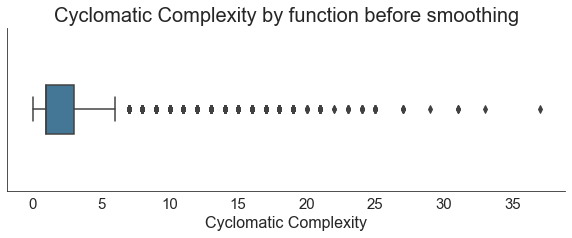

In [21]:
fig, ax = plt.subplots(figsize=(10, 3))
g = sns.boxplot(x=final_juliet_c_fuzzy_cp["cc"],
                palette='mako', 
                ax=ax, 
                width=0.3)
g.set_title('Cyclomatic Complexity by function before smoothing', fontsize=20)
g.set_xlabel('Cyclomatic Complexity', fontsize=16)
g.tick_params(labelsize=15)
sns.despine()
sns.set_style("white")

g.figure.savefig("images/cc_presmooth.png")

It seems that we have some pretty significant outliers. So we'll apply the `smooth()` function, and only keep data within the 5-95th quantiles.

In [22]:
def smooth(df): 
    cols = ['cc'] # apply smoothing one or more features

    Q1 = df[cols].quantile(0.05) # change the lower bound as desired
    Q3 = df[cols].quantile(0.95) # change the upper bound as desired
    IQR = Q3 - Q1 # only keep data between the 5-95th quantiles

    df = df[~((df[cols] < (Q1 - 1.5 * IQR)) |(df[cols] > (Q3 + 1.5 * IQR))).any(axis=1)]
    return df

In [23]:
final_juliet_c_fuzzy_cp_smooth = smooth(final_juliet_c_fuzzy_cp)

Now, let's replot the data. 

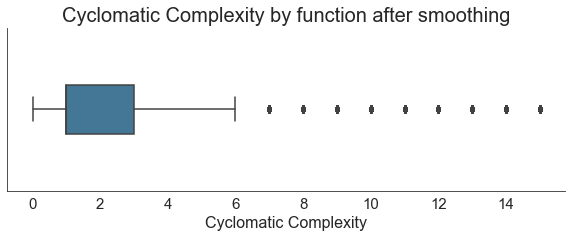

In [24]:
fig, ax = plt.subplots(figsize=(10, 3))
g = sns.boxplot(x=final_juliet_c_fuzzy_cp_smooth["cc"],
                palette='mako', 
                ax=ax,
                width=0.3)
g.set_title('Cyclomatic Complexity by function after smoothing', fontsize=20)
g.set_xlabel('Cyclomatic Complexity', fontsize=16)
g.tick_params(labelsize=15)
sns.despine()
sns.set_style("white")

g.figure.savefig("images/cc_aftersmooth.png")

It seems that smoothing allowed us to reduce the noise in our dataset, which in turn creates a greater emphasis on the data within the primary quantiles.

## Data Transformation

After the dataset has been extracted and cleaned, the next steps involve performing one or more transformations of the data. Iris provides data aggregation, normalization, and feature construction transformations. 

### Aggregation

By default, Iris collected the cyclomatic complexity for every function in the sample and stores it as a nested list. This creates the feature called `fun_complexity`. Sometimes, users may want to view their data by individual functions and not at a file level. In this case, the `cyclomatic complexity` data can be partitioned and organized using the following functions. 

The `complexities(df)` function will call the `cyclomatic_complexity(cc)` function using lambda for each test case in the sample (i.e. row). The logic for these functions are as follows: 

1. create a new DataFrame, `new_df` from the nested list, `fun_complexity` to include the `function_name` and `complexity` for each function in the sample
2. using `new_df` get the `min`, `max`, and `mean` complexities for each `function_name`
3. add this information to the original `df`, as the `complexity_min`, `complexity_max`, `complexity_mean`

In [ ]:
def cyclomatic_complexity(cc): 
    row_df = pd.DataFrame({'complexity_list': row})
    new_df = pd.DataFrame(row_df['complexity_list'].to_list(), columns=['function_name', 'complexity'])
    min = new_df['complexity'].min()
    max = new_df['complexity'].max()
    mean = new_df['complexity'].mean()
    return min, max, mean

In [ ]:
def complexities(df):
    '''
    fun_complexity = [[non_fun_stub_name, complexity]...]
    max complexity, min complexity, average complexity
    '''
    df.fun_complexity = df.fun_complexity.apply(literal_eval)
    nested_list = df['fun_complexity']
    complexities_df = pd.DataFrame({'fun_complexity': nested_list})

    complexities_df[['complexity_min', 'complexity_max', 'complexity_mean']] = complexities_df.apply(lambda row: complex_stats(row['fun_complexity']), axis=1, result_type="expand")
    return complexities_df.drop(['fun_complexity'], axis=1)

### Normalization

During normalization, features are scaled to fit within a standardized or smaller range. Normalizing the feature values forces all features to have an equal weight, and can prevent features with large ranges (e.g., file size) from outweighing features with small ranges (e.g., cyclomatic complexity). Treating all features equally, can also reduce the domain expertise required to distinguish the importance of one feature from another. Common normalization techniques include scaling (e.g., min-max, linear, or log scaling), clipping, and using a z-score.

Iris provides the user with the option of normalizing features using the function, $normalize()$. $normalize()$ applies min-max scaling using the following formula, 

\begin{equation}
x^{\prime}=\frac{x-\min (x)}{\max (x)-\min (x)}
\end{equation}

Where $x$ is the original value, and $x^{\prime}$ is the normalized value. The `normalize(df)` function can be used to optionally normalize any feature in the dataframe, or an entire dataframe. Like many of these functions, the `normalize(df)` function should be used as appropriate, depending on the users specific use case.

In [ ]:
def normalize(df): 
    df = (df - df.min()) / (df.max() - df.min())
    return df

### Feature Construction

During the feature construction phase, new features are created from existing features. The most noteworthy feature constructed by Iris (specifically for X86 binaries) is `fuzzy_instructions`. By default, Iris extracts the function sequence for each disassembled function in a binary sample. To prepare the instruction sequence to be compatible with machine learning algorithms, we perform a number of transformations on the original feature. 

First, we tokenize each instruction sequence into individual words, i.e., opcodes. Then, convert all characters to lowercase, and remove all punctuation and assembly size qualifiers such as `dword` and `byte`. Finally, a number of standardization's are performed. For example, each memory addresses is converted to `addr`, each conditional and non conditional jump is converted to `jump`, and all remaining numeric constants were converted to `num`. The resulting instruction set loosely resembles X86, and thus we refer to this feature as `fuzzy_instructions`. For example, the following transformation would occur: 

`"SUB RSP,0x10" ---> "sub rsp num"`

In [1663]:
def clean_fuzzy(df): 
    df['fuzzy_instr'] = df['fun_inst'].apply(lambda x: " ".join(x)) #convert to space separated string
    df['fuzzy_instr'] = df['fuzzy_instr'].apply(lambda x: x.lower()) #make lower
    df['fuzzy_instr'] = df['fuzzy_instr'].apply(lambda x: re.sub(',', ' ', x)) # replace commas with spaces
    words = ['qword', 'dword', 'genreplacement', 'word', 'ptr', 'dptr', 'byte', '[', ']', '-', '.', 'ds: ', 'es: ', '+', '-', '*']
    big_regex = re.compile('|'.join(map(re.escape, words)))
    df['fuzzy_instr'] = df['fuzzy_instr'].apply(lambda x: big_regex.sub('', x)) # remove stop words
    df['fuzzy_instr'] = df['fuzzy_instr'].apply(lambda x: re.sub(r'0x[a-zA-Z0-9]{6,}', 'addr', x)) # replace hex addr with addr
    df['fuzzy_instr'] = df['fuzzy_instr'].apply(lambda x: re.sub(r'0x[a-zA-Z0-9]{1,}', 'num', x)) # replace hex nums with num
    df['fuzzy_instr'] = df['fuzzy_instr'].apply(lambda x: re.sub('[^a-zA-Z ]', ' ', x)) # replace non alphanumerics with space
    df['fuzzy_instr'] = df['fuzzy_instr'].apply(lambda x: ' '.join(x.split())) # delete empty whitespace
    return df

In [1664]:
df = clean_fuzzy(df)

In [33]:
final_juliet_c_fuzzy[['fun_inst','clean_fuzzy_instructions']].iloc[11120]

fun_inst                    ['PUSH RBP', 'MOV RBP,RSP', 'SUB RSP,0x30', 'M...
clean_fuzzy_instructions    push sbp mov rbp rsp sub num mov rbp addr mov ...
Name: 11120, dtype: object

## Feature Vectors

# Data Mining & Machine Learning

## Data Similarity

### Theoretical Limitations

Rice's Theorem states that all non-trivial properties of recursively enumerable languages are undecidable. Undecidable in this case means that there does not exist a [Turing] machine that can solve this problem in the general case. An analog of Rice's Theorem helps us discern whether we should even attempt to decide if two programs are semantically similar \cite{hopcroft},

!<center>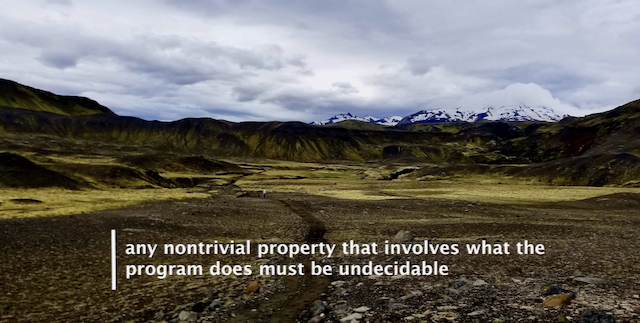</center>

Ergo, determining whether two programs are semantically similar can be reduced to determining whether a program will halt, and thus is undecidable. All hope is not lost, however. By changing the scope our question we can pivot from an undecidable problem, to one that is certainly surmountable. 

Rather than examining the syntactic properties of a program, we will instead compare the feature vector for each program to determine whether two programs are similar.

### (re)scoping the problem

Rescoping the problem is precisely what many machine learning classifiers, e.g., $k$-nearest neighbors, attempt to achieve. By representing each sample as a feature vector, we can plot each vector as a point in an $n$-dimensional space, where $n$ is equal to the number of distinct features in the vector. 

We can then calculate the geometric distance between any two points, or in our case, binary samples. The closer two points are the more similar the feature vectors are for those samples. Or, the farther two points are from one another, the more dissimilar the feature vectors are for those samples.

There are several methods to calculate the distance between two points; in general, a distance metric must satisfy the following four properties\cite{kubatIntroductionMachineLearning2017}: 

1. The distance must never be negative
2. The distance between two identical feature vectors, $x$ and $y$, is zero
3. The distance from $x$ to $y$ is the same as the distance from $y$ to $x$
4. The metric must satisfy the triangular inequality: $d(x,y) + d(y,z) >= d(x,z)$

## Distance Measurements

### Cosine Similarity

In [258]:
def cosine_similarity(series):
    series_sets = [set(x) for x in series]
    all_cosine_distances = list()
    for set1 in series_sets:
        setn_cosine = [np.dot(set1, set2) / (np.linalg.norm(set1) * np.linalg.norm(set2)) for set2 in series]
        all_cosine_distances.append(setn_jaccard)
    return np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))

### Euclidean Distance

One method to determine the distance between points in an $n$-dimensional space is to calculate the Euclidean distance, or the hypotenuse between the points. In a two-dimensional space, the hypotenuse can be calculated using the Pythagorean theorem, and can be generalized for $n$-dimensions as follows,

\begin{equation}
    d(\vec{x}, \vec{y})=\|\vec{x}-\vec{y}\|=\sqrt{\left(x_{1}-y_{1}\right)^{2}+\left(x_{2}-y_{2}\right)^{2} \ldots\left(x_{n}-y_{n}\right)^{2}}
\end{equation}

More succinctly, the Euclidean distance between two samples, $x$ and $y$, can be calculated using the following formula:

\begin{equation}
d_{E}(\mathbf{x}, \mathbf{y})=\sqrt{\Sigma_{i=1}^{n}\left(x_{i}-y_{i}\right)^{2}}
\end{equation}

### Scalar Distance

To calculate the scalar distance between numerical values, we can simply subtract the values from one another

In [255]:
def scalar_distance(series):
    all_scalar_distances = list()
    for scalar1 in series:
        scalars = [abs(scalar1-scalar2) for scalar2 in series]
        all_scalar_distances.append(scalars)
    return all_scalar_distances

### Jaccard Distance

When a feature is comprised of scalar values, e.g., maximum complexity or number of functions, the function to calculate the distance between $x_{i}$ and $y_{i}$ merely involves the subtraction of scalar values. However, when a feature contains a set or list of values the the function to calculate the distance between $x_{i}$ and $y_{i}$ must include set operations. To this end, the \textbf{Jaccard distance} or Jaccard dissimilarity coefficient can be used to calculate the distance between features containing a set of values.

\begin{equation}
    d_{J}(A, B)=1-J(A, B)=\frac{|A \cup B|-|A \cap B|}{|A \cup B|}
\end{equation}

The Jaccard distance measures dissimilarity between two sets (opposed to the Jaccard Index which measures similarity), and is obtained by dividing the difference of the sizes of the set union and set intersection, by the size of the set union. Consider the feature, \textit{Unique Strings}, which specifies a list of unique strings for every binary sample. To calculate the difference between each set of strings, we could apply the Jaccard Distance formula. Figure \ref{fig:jaccard_ex} provides a short example that includes the unique strings feature for three binary samples. The \textit{Jaccard Distance} column shows the Jaccard distance from each sample to every other sample in the dataset. The Jaccard distance from any sample to itself is zero. The Jaccard distance from $sample 0$ to $sample 0$ is 0.5, and the calculation is as follows:

\begin{equation}
    d_{J}(sample0, sample1)=\frac{| sample0 \cup sample1|-| sample0 \cap sample1|}{| sample0 \cup sample1|}=\frac{4-2}{4}=0.5
\end{equation}


Here's a simple function to calculate the jaccard distance between every object in a particular series in our dataframe:

In [214]:
def jaccard_distance(series):
    series_sets = [set(x) for x in series]
    all_jaccard_distances = list()
    for set1 in series_sets:
        setn_jaccard = [round((len(set1.union(set2)) - len(set1.intersection(set2))) / len(set1.union(set2)), 4) for set2 in series]
        all_jaccard_distances.append(setn_jaccard)
    return all_jaccard_distances

We can apply this function to any column containing lists, sets, or even scalar values. Regardless of the input, the $Jaccard Distance()$ function will interpret it as a set. This means that duplicates will be deleted.

Let's create a sample DataFrame, and apply the function to the 'Unique Strings' column

In [203]:
example ={'Binary Sample':['sample_0', 'sample_1', 'sample_2'], 
       'Unique Strings': [['hello', 'yes', 'password'], 
                     ['yes', 'password', 'no'], 
                     ['yes', 'welcome']], 
       'Functions': ['myfun1', 'myfun2', 'myfun1'], 
       'File Entropy': [3, 4, 0], 
       'Number functions': [10000, 20000, 12000]}

In [204]:
example_df = pd.DataFrame(data=example)

In [205]:
example_df

,Binary Sample,Unique Strings,Functions,File Entropy,Number functions
0,sample_0,"[hello, yes, password]",myfun1,3,10000
1,sample_1,"[yes, password, no]",myfun2,4,20000
2,sample_2,"[yes, welcome]",myfun1,0,12000


Apply the jaccard_distance() function

In [ ]:
example_df['Jaccard Distance'] = example_df.apply(lambda x: jaccard_distance(example_df['Unique Strings']))

In [253]:
example_df['Scalar Distance'] = example_df.apply(lambda x: scalar_distance(example_df['Number functions']))

In [254]:
example_df

,Binary Sample,Unique Strings,Functions,File Entropy,Number functions,Jaccard Distance,Scalar Distance
0,sample_0,"[hello, yes, password]",myfun1,3,10000,"[0.0, 0.5, 0.75]","[0, 10000, 2000]"
1,sample_1,"[yes, password, no]",myfun2,4,20000,"[0.5, 0.0, 0.75]","[10000, 0, 8000]"
2,sample_2,"[yes, welcome]",myfun1,0,12000,"[0.75, 0.75, 0.0]","[2000, 8000, 0]"


In [230]:
example_df[['Binary Sample', 'Jaccard Distance']]

,Binary Sample,Jaccard Distance
0,sample_0,"[0.0, 0.5, 0.75]"
1,sample_1,"[0.5, 0.0, 0.75]"
2,sample_2,"[0.75, 0.75, 0.0]"


In [236]:
unique_strings_jaccard_df = pd.DataFrame(example_df['Jaccard Distance'].to_list())

In [237]:
unique_strings_jaccard_df

,0,1,2
0,0.00,0.50,0.75
1,0.50,0.00,0.75
2,0.75,0.75,0.00


Now, we can easily visualize the results, or in this case how different the unique strings are for each sample by create a Heatmap. 

In [227]:
import seaborn as sns
import matplotlib.pyplot as plt

In [238]:
axis_labels = example_df['Binary Sample'].to_list() # labels for x/y-axis

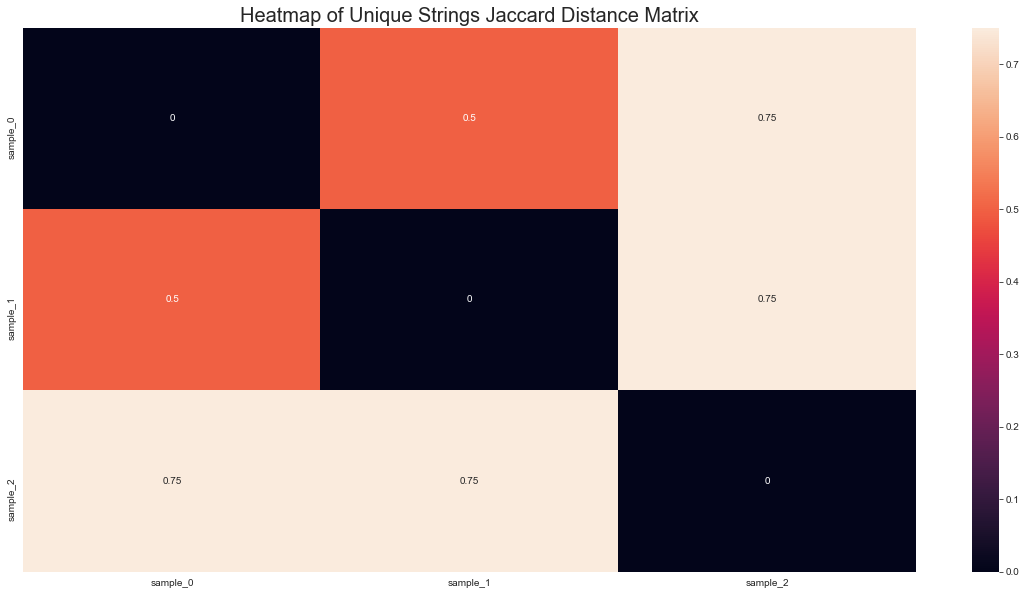

In [241]:
fig, ax = plt.subplots(figsize=(20,10))
g = sns.heatmap(unique_strings_jaccard_df, annot=True, xticklabels=axis_labels, yticklabels=axis_labels)
g.axes.set_title('Heatmap of Unique Strings Jaccard Distance Matrix', fontsize=20)
sns.set_style("white")

Now, we can use the distance DataFrames to calculate the Euclidean distance between each sample:

In [256]:
uniqueStrings_distance_df = pd.DataFrame(example_df['Jaccard Distance'].to_list())

In [257]:
functions_distance_df = pd.DataFrame(example_df['Scalar Distance'].to_list())

In [ ]:
def eucl_distance(df_list):
    euclidean_df = 
    
    result = scaled_complexity_matrix.pow(2) + scaled_size_matrix.pow(2) + scaled_entropy_matrix.pow(
        2) + real_strings_dist_matrix.pow(2) + real_opcodes_dist_matrix.pow(2) + real_funs_dist_matrix.pow(2)
    print('\tresult square complete')

    # result = result.applymap(lambda x: math.sqrt(x))
    # max_element_size = 6  # added four features,each with max value of 1
    result = result.applymap(lambda x: (1 / (1 + math.sqrt(x)))) # take the compliment of the euclidean similarity to get differences
    print('\tfinal result (sqrt) complete')
    return result


```{bibliography}
:style: unsrt
```